# Demo
Integrating sub-cellular spots into single-cellular spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [3]:
# We do not use negative control for now
#data_preper.simulate_negative_control(ratio_samplingFrom=0.2, negative_samples_proportion=0.2, ratio_mask=0.7)
#data_preper

In [4]:
# Step 2. Train a local classifier
# The q-Proximity classifier is a good model to measure a cell's identity
clf = pytacs.QProximityClassifier(threshold_confidence=0.75, n_PCs=5, q=0.8)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [5]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=1000,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.QProximityClassifier object at 0x7f5cce12a420>
    + threshold_confidence: 0.75
    + has_negative_control: False
- max_spots_per_cell: 1000
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [6]:
# Add 5 iterations for demo. In actual use, set max_iter to >100
sph.run_segmentation(
    n_spots_add_per_step=10,
    coverage_to_stop=0.8,
    max_iter=5,
    verbose=False,
    warnings=False,
    print_summary=True,
)

--- Summary ---
Queried 5 spots (with replacement), of which 4 made up confident single cells.
Classes total (this round): {0: 1, 1: 3}
Coverage: 8.30%
--- --- --- --- ---



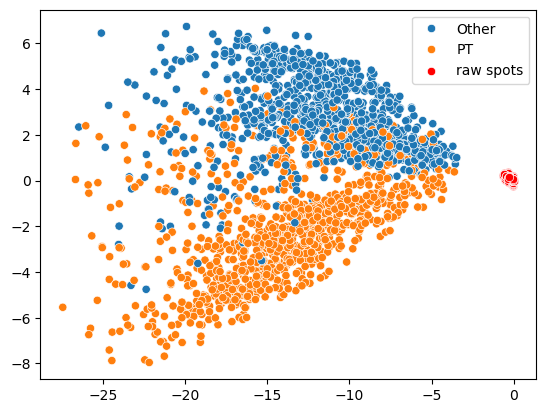

In [7]:
# See PC embeddings before intergration
import numpy as np
import pytacs.utils

xx = np.log1p(data_preper.sn_adata.X) @ clf._PC_loadings.T

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=xx[:,0],y=xx[:,1],hue=data_preper.sn_adata.obs['cell_type'])
X_sp_submatrix = pytacs.utils.subCountMatrix_genes2InGenes1(
    X=data_preper.sp_adata.X.toarray(),
    genes1=data_preper.sn_adata.var.index,
    genes2=data_preper.sp_adata.var.index
)
xx_sp = np.log1p(X_sp_submatrix) @ clf._PC_loadings.T
sns.scatterplot(x=xx_sp[:,0],y=xx_sp[:,1],c='r',label='raw spots')
plt.show()

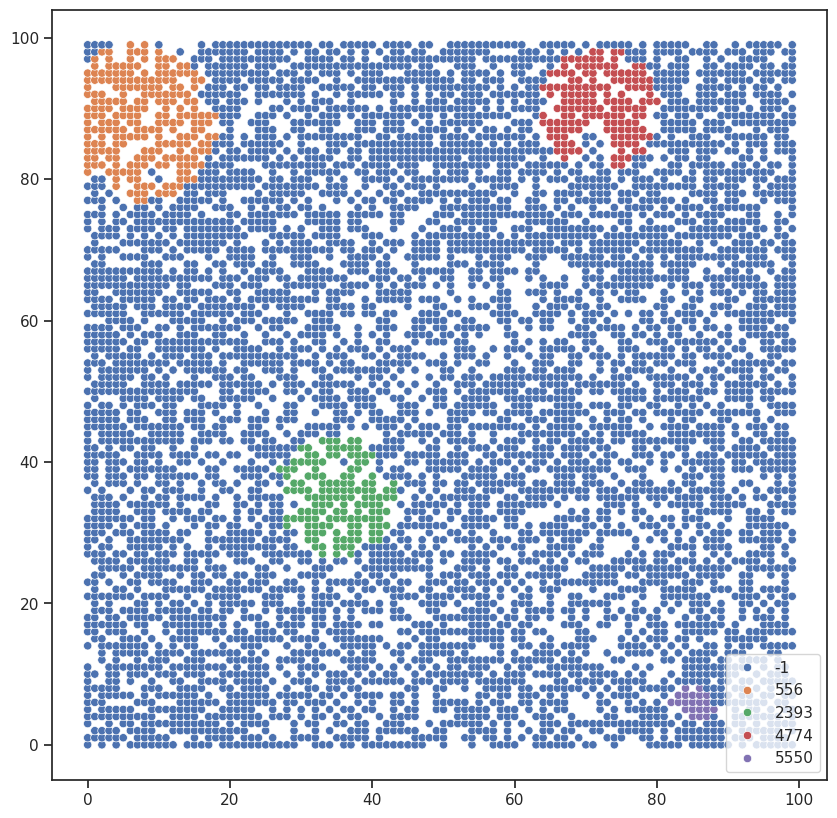

In [8]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sph.run_plotNewIds()
plt.show()

In [9]:
# Step 4. Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)
print(sp_singleCell)

AnnData object with n_obs × n_vars = 4 × 5227
    obs: 'x', 'y', 'old_index', 'confidence', 'cell_type'


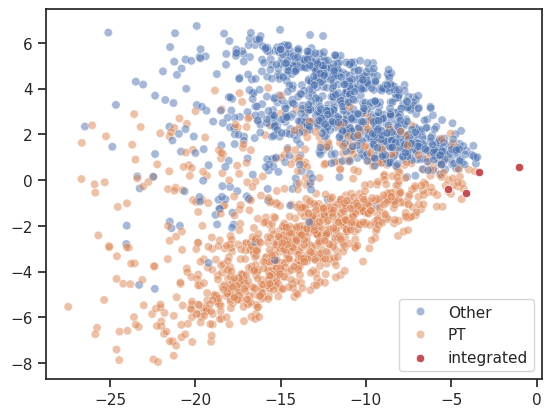

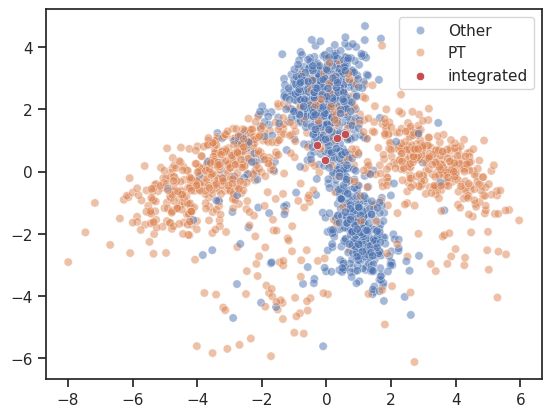

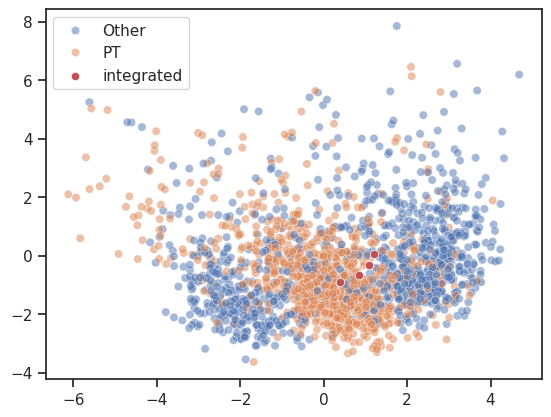

In [10]:
# See PCs after integration
import numpy as np
import pytacs.utils
import matplotlib.pyplot as plt
import seaborn as sns

xx = np.log1p(data_preper.sn_adata.X) @ clf._PC_loadings.T

X_sp_submatrix = pytacs.utils.subCountMatrix_genes2InGenes1(
    X=sp_singleCell.X.toarray(),
    genes1=data_preper.sn_adata.var.index,
    genes2=sp_singleCell.var.index
)
xx_sp = np.log1p(X_sp_submatrix) @ clf._PC_loadings.T


sns.scatterplot(x=xx[:,0],y=xx[:,1],hue=data_preper.sn_adata.obs['cell_type'],alpha=0.5)
sns.scatterplot(x=xx_sp[:,0],y=xx_sp[:,1],c='r', label='integrated')
plt.show()

sns.scatterplot(x=xx[:,2],y=xx[:,3],hue=data_preper.sn_adata.obs['cell_type'],alpha=0.5)
sns.scatterplot(x=xx_sp[:,2],y=xx_sp[:,3],c='r', label='integrated')
plt.show()

sns.scatterplot(x=xx[:,3],y=xx[:,4],hue=data_preper.sn_adata.obs['cell_type'],alpha=0.5)
sns.scatterplot(x=xx_sp[:,3],y=xx_sp[:,4],c='r', label='integrated')
plt.show()

In [11]:
clf.classes

array(['PT', 'Other'], dtype='<U5')

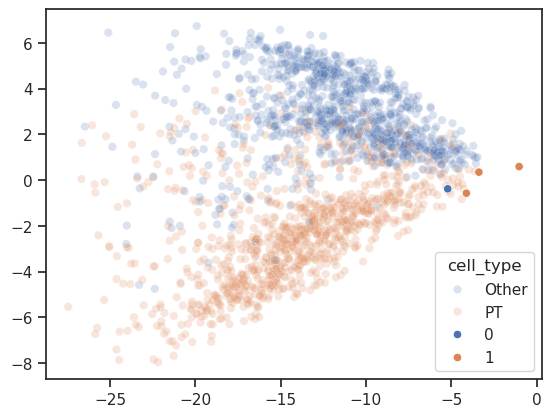

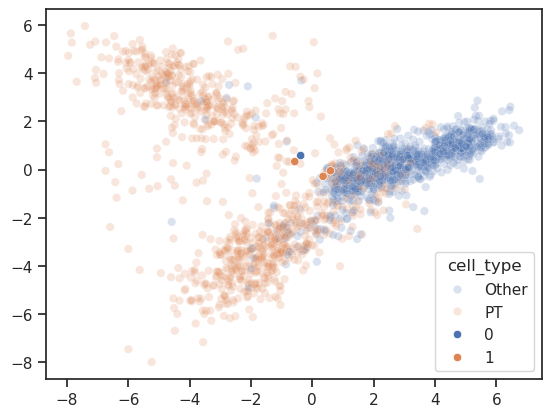

In [12]:
# See labels

sns.scatterplot(x=xx[:,0],y=xx[:,1],hue=data_preper.sn_adata.obs['cell_type'],alpha=0.2)
sns.scatterplot(x=xx_sp[:,0],y=xx_sp[:,1],hue=sp_singleCell.obs['cell_type'])
plt.show()

sns.scatterplot(x=xx[:,1],y=xx[:,2],hue=data_preper.sn_adata.obs['cell_type'],alpha=0.2)
sns.scatterplot(x=xx_sp[:,1],y=xx_sp[:,2],hue=sp_singleCell.obs['cell_type'])
plt.show()

In [13]:
sp_singleCell.obs

,x,y,old_index,confidence,cell_type
556,7,88,"7,88",0.750620,0
2393,35,35,"35,35",0.764268,1
4774,72,90,"72,90",0.758186,1
5550,85,6,"85,6",0.751861,1


In [14]:
# Try SVC classifier

In [15]:
import pytacs
import scanpy as sc

In [16]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('snRNA_mouse_demo.h5ad'),
    sp_adata=sc.read_h5ad('spRNA_mouse_demo.h5ad'),
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- sn_adata_withNegativeControl: _UNDEFINED
- normalized: False
--- --- --- --- ---



In [17]:
# Step 2. Train a local classifer
clf = pytacs.SVM(threshold_confidence=0.75, log1p=True, normalize=True)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [18]:
# Step 3. Integrate spatial spots into single-cell spots
sph = pytacs.SpatialHandler(adata_spatial=data_preper.sp_adata,
                            local_classifier=clf,
                            max_spots_per_cell=81,
                            threshold_adjacent=1.2,
                            )
print(sph)

--- Spatial Handler (pytacs) ---
- adata_spatial: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
- threshold_adjacent: 1.2
- local_classifier: <pytacs.classifier.SVM object at 0x7f5d97dee930>
    + threshold_confidence: 0.75
    + has_negative_control: False
- max_spots_per_cell: 81
- scale_rbf: 1.0
- filtrations: 0 fitted
- single-cell segmentation:
    + new samples: 0
    + AnnData: _UNDEFINED
--- --- --- --- --- ---



In [19]:
sph.run_segmentation(
    n_spots_add_per_step=3,
    coverage_to_stop=0.8,
    max_iter=50,
    verbose=False,
    warnings=False,
    print_summary=True,
)

--- Summary ---
Queried 50 spots (with replacement), of which 44 made up confident single cells.
Classes total (this round): {1: 43, 0: 1}
Coverage: 7.86%
--- --- --- --- ---



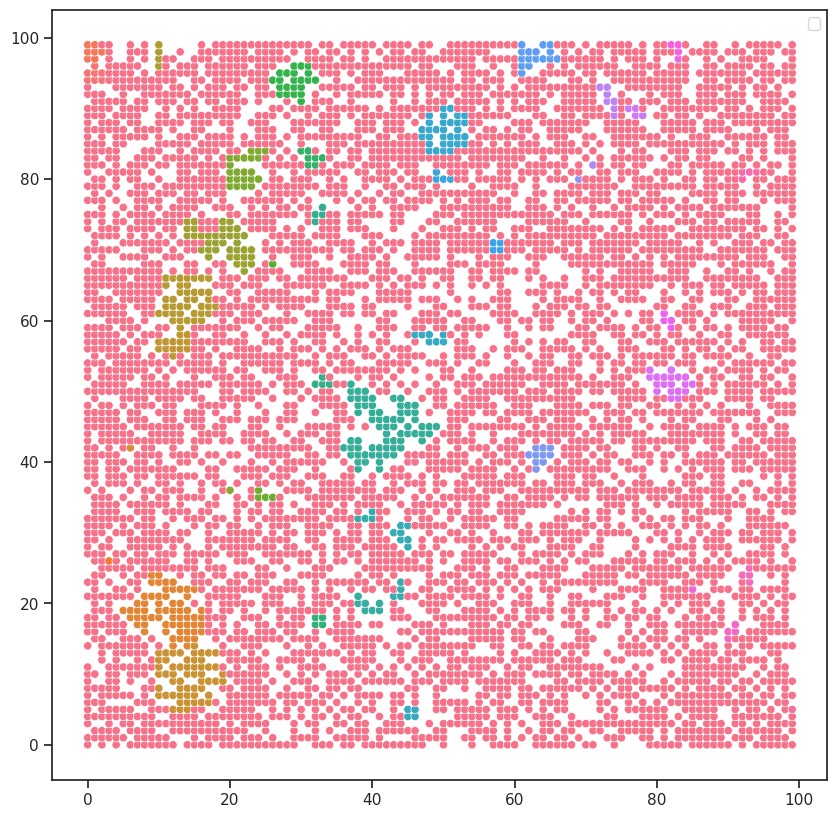

In [26]:
# See the integrated spots
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.set_theme(style='ticks')
sph.run_plotNewIds()
plt.legend('')
plt.show()

In [21]:
# Step 4. Get integrated single-cell level ST data
sp_singleCell = sph.run_getSingleCellAnnData(cache=True, force=True)
print(sp_singleCell)

AnnData object with n_obs × n_vars = 44 × 5227
    obs: 'x', 'y', 'old_index', 'confidence', 'cell_type'


In [22]:
clf.classes

array(['PT', 'Other'], dtype='<U5')

In [23]:
sp_singleCell.obs

,x,y,old_index,confidence,cell_type
69,0,95,"0,95",0.868440,1
70,0,97,"0,97",0.839002,1
240,3,26,"3,26",0.829303,1
453,6,42,"6,42",0.772115,0
779,10,99,"10,99",0.811460,1
790,11,19,"11,19",0.831007,1
886,12,57,"12,57",0.856028,1
989,14,10,"14,10",0.809299,1
1022,14,63,"14,63",0.787864,1
1031,14,73,"14,73",0.868433,1
